In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import STL

from utils import *

plt.style.use("ggplot")
pd.set_option("display.precision", 3)

# Table of contents
1. [Some simple statistics](#some-simple-statistics)
2. [ACF features](#acf-features)
3. [STL features](#stl-features)
5. [Exploring Australian tourism data](#exploring-australian-tourism-data)
6. [Exercises](#exercises)

# [Some simple statistics](https://otexts.com/fpppy/nbs/04-features.html#some-simple-statistics)

In [2]:
aus_tourism = pd.read_csv("data/aus_tourism.csv", parse_dates=["ds"])
aus_tourism.head()

,unique_id,ds,y
0,Adelaide-South Australia-Business,1998-03-31,135.078
1,Adelaide-South Australia-Business,1998-06-30,109.987
2,Adelaide-South Australia-Business,1998-09-30,166.035
3,Adelaide-South Australia-Business,1998-12-31,127.160
4,Adelaide-South Australia-Business,1999-03-31,137.449


In [3]:
mean_df = aus_tourism.groupby("unique_id", as_index=False)["y"].mean()
mean_df.sort_values(by="y").head(10)

,unique_id,y
158,Kangaroo Island-South Australia-Other,0.340
182,MacDonnell-Northern Territory-Other,0.449
294,Wilderness West-Tasmania-Other,0.478
34,Barkly-Northern Territory-Other,0.632
86,Clare Valley-South Australia-Other,0.898
38,Barossa-South Australia-Other,1.022
154,Kakadu Arnhem-Northern Territory-Other,1.043
170,Lasseter-Northern Territory-Other,1.136
298,Wimmera-Victoria-Other,1.146
183,MacDonnell-Northern Territory-Visiting,1.175


In [4]:
summary_stats = aus_tourism.groupby("unique_id", as_index=False)["y"].agg(
    [
        ("min", "min"),
        ("p25", lambda x: np.percentile(x, 25)),
        ("median", "median"),
        ("p75", lambda x: np.percentile(x, 75)),
        ("max", "max"),
    ]
)
summary_stats.head(10)

,unique_id,min,p25,median,p75,max
0,Adelaide Hills-South Australia-Business,0.000,0.000,1.255,3.920,28.602
1,Adelaide Hills-South Australia-Holiday,0.000,5.768,8.516,14.060,35.751
2,Adelaide Hills-South Australia-Other,0.000,0.000,0.908,2.093,8.953
3,Adelaide Hills-South Australia-Visiting,0.778,8.908,12.207,16.806,81.102
4,Adelaide-South Australia-Business,68.725,133.893,152.577,176.936,242.494
5,Adelaide-South Australia-Holiday,108.033,134.627,153.945,172.257,223.557
6,Adelaide-South Australia-Other,25.902,43.866,53.809,62.523,107.495
7,Adelaide-South Australia-Visiting,136.611,178.916,205.582,229.299,269.536
8,Alice Springs-Northern Territory-Business,1.008,9.133,13.324,18.456,34.077
9,Alice Springs-Northern Territory-Holiday,2.809,16.851,31.524,44.784,76.541


# [ACF features](https://otexts.com/fpppy/nbs/04-features.html#acf-features)

In [5]:
acf_feat = aus_tourism.groupby("unique_id", as_index=False)["y"].agg(
    [
        ("x_acf1", lambda x: acf(x, nlags=1)[1]),
        ("x_acf10", lambda x: np.sum(np.square(acf(x, nlags=10)[1:]))),
        ("diff1_acf1", lambda x: acf(np.diff(x, n=1), nlags=1, missing="drop")[1]),
        (
            "diff_acf10",
            lambda x: np.sum(
                np.square(acf(np.diff(x, n=1), nlags=10, missing="drop")[1:])
            ),
        ),
        ("diff2_acf1", lambda x: acf(np.diff(x, n=2), nlags=1, missing="drop")[1]),
        (
            "diff2_acf10",
            lambda x: np.sum(
                np.square(acf(np.diff(x, n=2), nlags=10, missing="drop")[1:])
            ),
        ),
        ("seas_acf1", lambda x: acf(x, nlags=4)[4]),
        ("seas_pacf", lambda x: pacf(x, nlags=4)[4]),
    ]
)
acf_feat.head(10)

,unique_id,x_acf1,x_acf10,diff1_acf1,diff_acf10,diff2_acf1,diff2_acf10,seas_acf1,seas_pacf
0,Adelaide Hills-South Australia-Business,0.071,0.134,-0.580,0.415,-0.750,0.746,-0.063,-0.118
1,Adelaide Hills-South Australia-Holiday,0.131,0.313,-0.536,0.500,-0.716,0.906,0.208,0.191
2,Adelaide Hills-South Australia-Other,0.261,0.330,-0.253,0.317,-0.457,0.392,0.075,0.044
3,Adelaide Hills-South Australia-Visiting,0.139,0.117,-0.472,0.239,-0.626,0.408,0.170,0.138
4,Adelaide-South Australia-Business,0.033,0.131,-0.520,0.463,-0.676,0.741,0.201,0.206
5,Adelaide-South Australia-Holiday,0.046,0.372,-0.343,0.614,-0.487,0.558,0.351,0.347
6,Adelaide-South Australia-Other,0.517,1.154,-0.409,0.383,-0.675,0.792,0.342,0.314
7,Adelaide-South Australia-Visiting,0.068,0.294,-0.394,0.452,-0.518,0.447,0.345,0.332
8,Alice Springs-Northern Territory-Business,0.217,0.367,-0.500,0.381,-0.658,0.587,0.315,0.260
9,Alice Springs-Northern Territory-Holiday,-0.007,2.113,-0.153,2.113,-0.274,1.551,0.729,0.546


# [STL features](https://otexts.com/fpppy/nbs/04-features.html#sec-stlfeatures)

In [6]:
def get_trend_strength(x, period):
    res_stl = STL(x, period=period, seasonal=13).fit()
    ft = max(0, 1 - np.var(res_stl.resid) / np.var(res_stl.trend + res_stl.resid))

    return ft


def get_seasonal_strength(x, period):
    res_stl = STL(x, period=period, seasonal=13).fit()
    fs = max(0, 1 - np.var(res_stl.resid) / np.var(res_stl.seasonal + res_stl.resid))

    return fs


def get_peak(x, period):
    res_stl = STL(x, period=period, seasonal=13).fit()
    peak = (np.argmax(res_stl.seasonal) + 1) % period
    if peak == 0:
        peak = period

    return peak


def get_trough(x, period):
    res_stl = STL(x, period=period, seasonal=13).fit()
    trough = (np.argmin(res_stl.seasonal) + 1) % period
    if trough == 0:
        trough = period

    return trough


def get_e_acf1(x, period):
    res_stl = STL(x, period=period, seasonal=13).fit()

    return acf(res_stl.resid, nlags=1)[1]


def get_e_acf10(x, period):
    res_stl = STL(x, period=period, seasonal=13).fit()

    return np.sum(np.square(acf(res_stl.resid, nlags=10)[1:]))

In [7]:
stl_feat = aus_tourism.groupby("unique_id", as_index=False)["y"].agg(
    [
        ("trend_strength", lambda x: get_trend_strength(x, period=4)),
        ("seasonal_strength", lambda x: get_seasonal_strength(x, period=4)),
        ("peak", lambda x: get_peak(x, period=4)),
        ("trough", lambda x: get_trough(x, period=4)),
        ("e_acf1", lambda x: get_e_acf1(x, period=4)),
        ("e_acf10", lambda x: get_e_acf10(x, period=4)),
    ]
)
stl_feat.head(10)

,unique_id,trend_strength,seasonal_strength,peak,trough,e_acf1,e_acf10
0,Adelaide Hills-South Australia-Business,0.460,0.168,3,4,-0.594,0.502
1,Adelaide Hills-South Australia-Holiday,0.531,0.295,2,4,-0.456,0.342
2,Adelaide Hills-South Australia-Other,0.590,0.407,2,2,-0.295,0.273
3,Adelaide Hills-South Australia-Visiting,0.487,0.248,4,3,-0.474,0.438
4,Adelaide-South Australia-Business,0.462,0.391,3,1,-0.538,0.577
5,Adelaide-South Australia-Holiday,0.578,0.638,1,2,-0.525,0.600
6,Adelaide-South Australia-Other,0.746,0.209,2,3,-0.368,0.412
7,Adelaide-South Australia-Visiting,0.449,0.476,1,2,-0.504,1.000
8,Alice Springs-Northern Territory-Business,0.552,0.302,3,1,-0.481,0.519
9,Alice Springs-Northern Territory-Holiday,0.379,0.832,3,1,-0.529,0.709


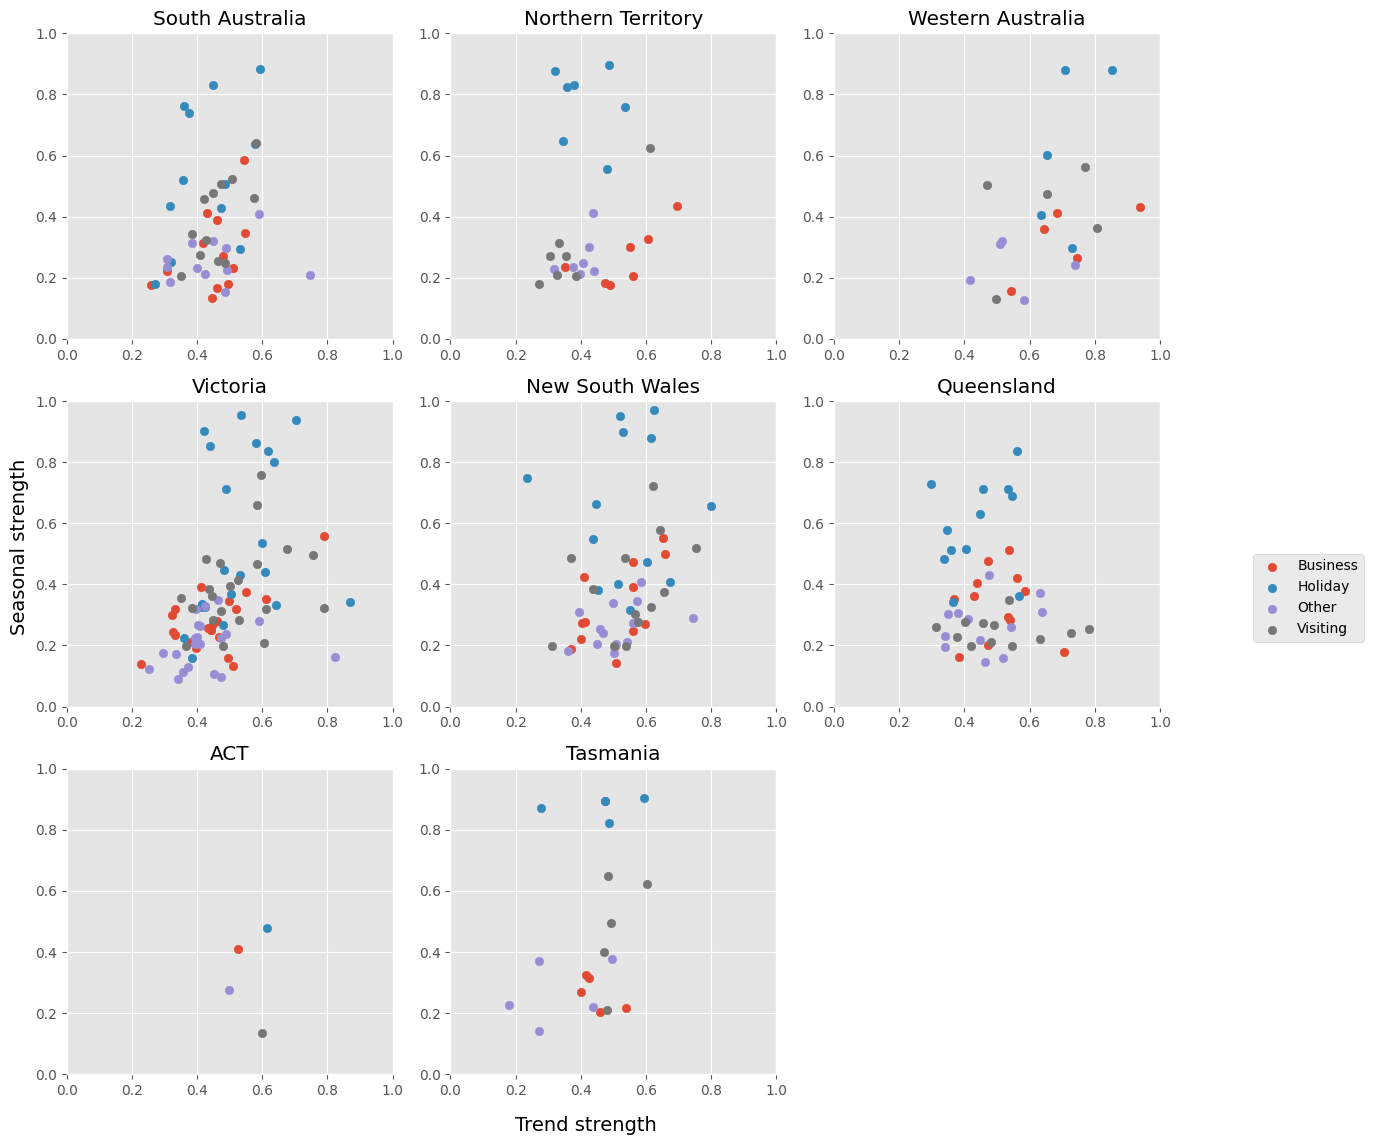

In [8]:
stl_feat[["region", "state", "purpose"]] = stl_feat["unique_id"].str.split(
    "-", expand=True
)

fig, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
unique_states = stl_feat["state"].unique()
all_handles = []
all_labels = []
for i, state in enumerate(unique_states):
    state_df = stl_feat[stl_feat["state"] == state].copy()
    ax = axs[i]
    for purpose in state_df["purpose"].unique():
        purpose_df = state_df[state_df["purpose"] == purpose]
        handle = ax.scatter(
            purpose_df["trend_strength"], purpose_df["seasonal_strength"], label=purpose
        )
        if purpose not in all_labels:
            all_handles.append(handle)
            all_labels.append(purpose)
    ax.set_title(state)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
fig.legend(
    all_handles,
    all_labels,
    loc="upper left",
    bbox_to_anchor=(1.05, 0.5),
)
fig.supxlabel("Trend strength", fontsize=14)
fig.supylabel("Seasonal strength", fontsize=14)

# Remove any empty subplots
for j in range(len(unique_states), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

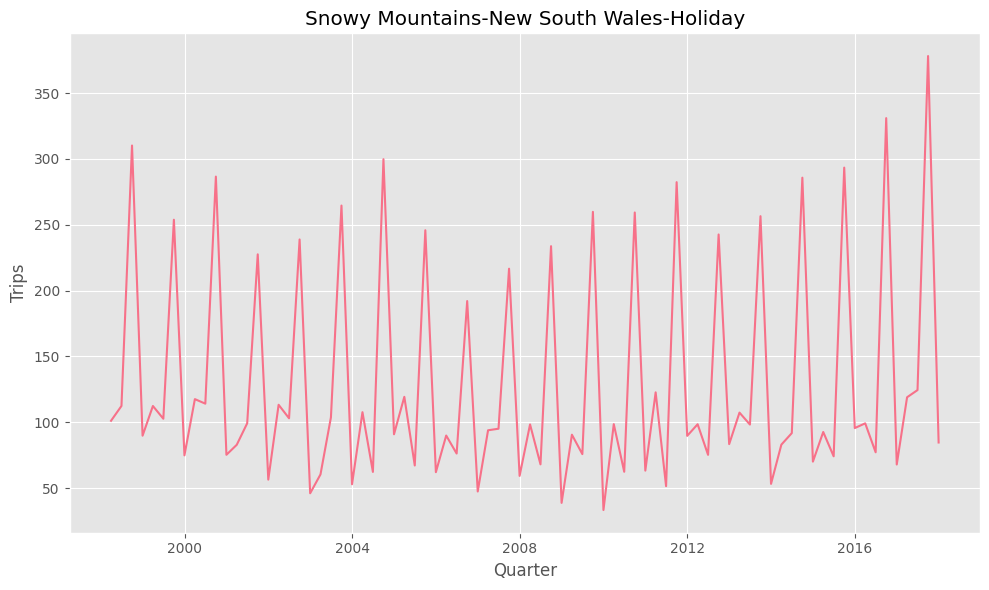

In [9]:
max_seasonal_strength_row = stl_feat.loc[stl_feat["seasonal_strength"].idxmax()]
max_unique_id = max_seasonal_strength_row["unique_id"]
aus_tourism["ds"] = pd.to_datetime(aus_tourism["ds"])
plot_series(
    aus_tourism,
    id_col="unique_id",
    ids=[max_unique_id],
    time_col="ds",
    target_col="y",
    xlabel="Quarter",
    ylabel="Trips",
    title=max_unique_id,
)

# [Exploring Australian tourism data](https://otexts.com/fpppy/nbs/04-features.html#exploring-australian-tourism-data)

In [10]:
seasonal_feat = pd.merge(acf_feat, stl_feat, on="unique_id")[
    ["unique_id", "seasonal_strength", "peak", "trough", "seas_acf1", "seas_pacf"]
]
seasonal_feat.head()

,unique_id,seasonal_strength,peak,trough,seas_acf1,seas_pacf
0,Adelaide Hills-South Australia-Business,0.168,3,4,-0.063,-0.118
1,Adelaide Hills-South Australia-Holiday,0.295,2,4,0.208,0.191
2,Adelaide Hills-South Australia-Other,0.407,2,2,0.075,0.044
3,Adelaide Hills-South Australia-Visiting,0.248,4,3,0.170,0.138
4,Adelaide-South Australia-Business,0.391,3,1,0.201,0.206


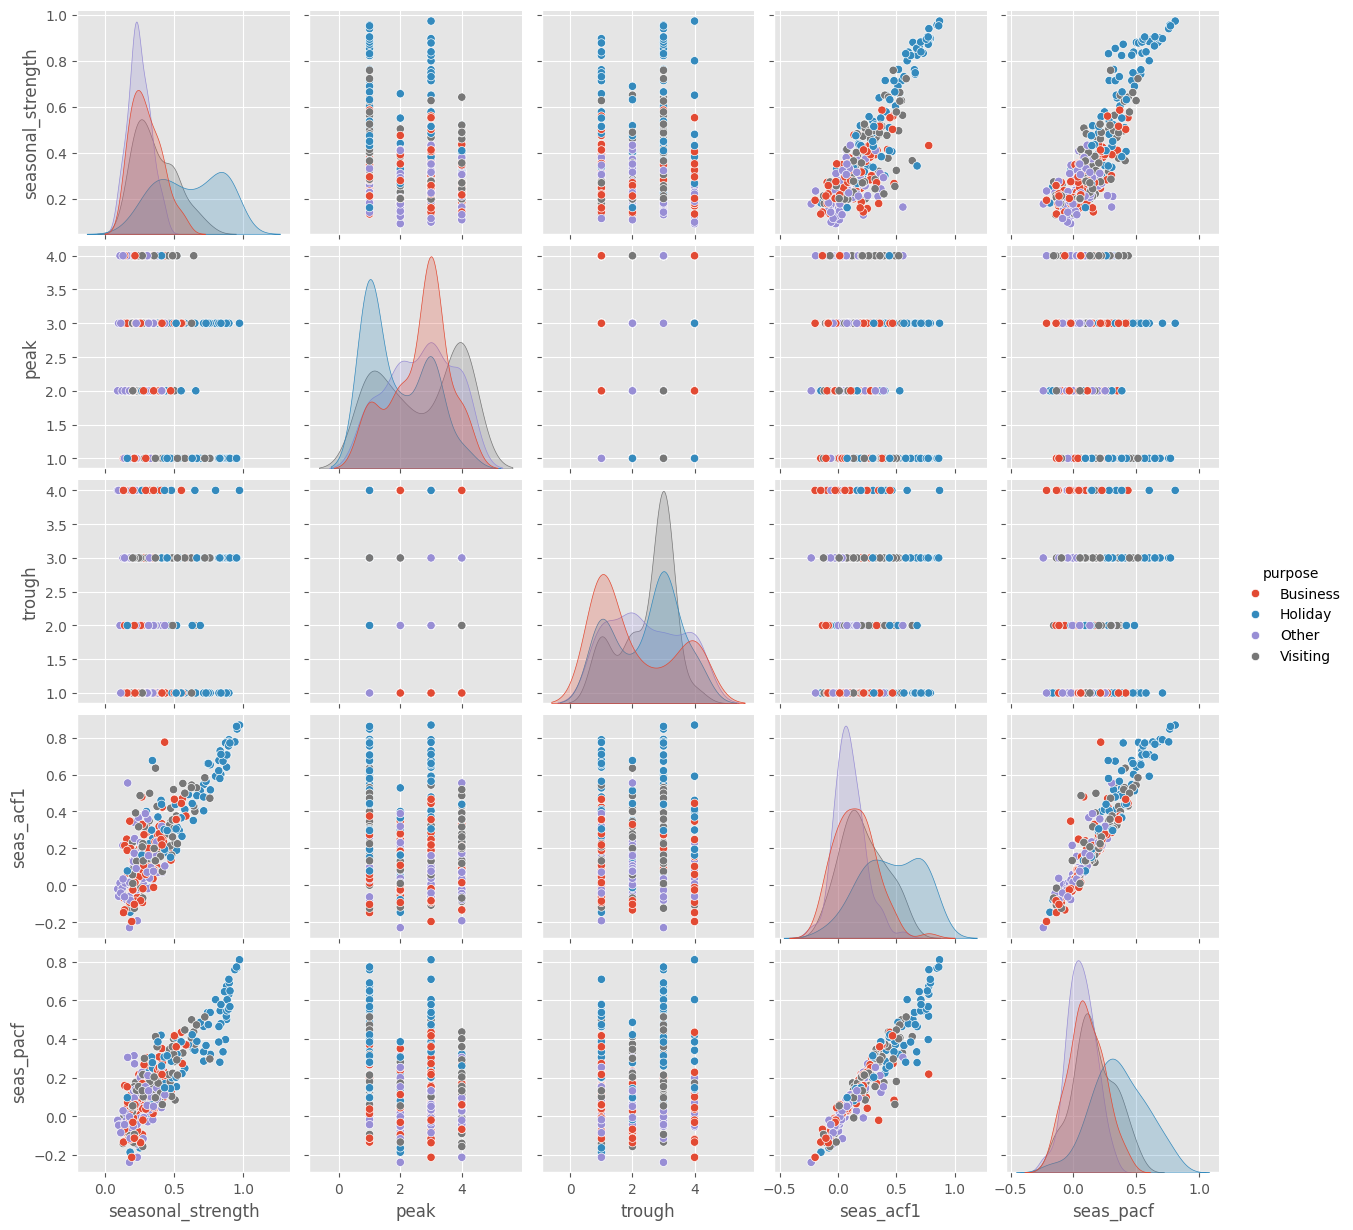

In [11]:
seasonal_feat[["region", "state", "purpose"]] = seasonal_feat["unique_id"].str.split(
    "-", expand=True
)
g = sns.pairplot(seasonal_feat, hue="purpose")
plt.show()

# [Exercises](https://otexts.com/fpppy/nbs/04-features.html#sec-feast-exercises)

## Question 1

In [12]:
pbs = pd.read_csv("data/PBS_unparsed.csv")
pbs["Month"] = pd.to_datetime(pbs["Month"])
pbs.head()

,Month,Concession,Type,ATC1,ATC1_desc,ATC2,ATC2_desc,Scripts,Cost
0,1991-07-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,18228,67877.0
1,1991-08-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15327,57011.0
2,1991-09-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14775,55020.0
3,1991-10-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15380,57222.0
4,1991-11-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14371,52120.0


In [13]:
pbs_feat = pbs.groupby(["Concession", "Type", "ATC1", "ATC2"])["Cost"].agg(
    [("mean", "mean"), ("std", "std")]
)
pbs_feat.head()

mean        std
Concession   Type        ATC1 ATC2                      
Concessional Co-payments A    A01   6.767e+04  1.476e+04
                              A02   1.646e+07  7.499e+06
                              A03   4.762e+05  3.707e+05
                              A04   4.634e+05  1.540e+05
                              A05   1.476e+05  7.419e+04

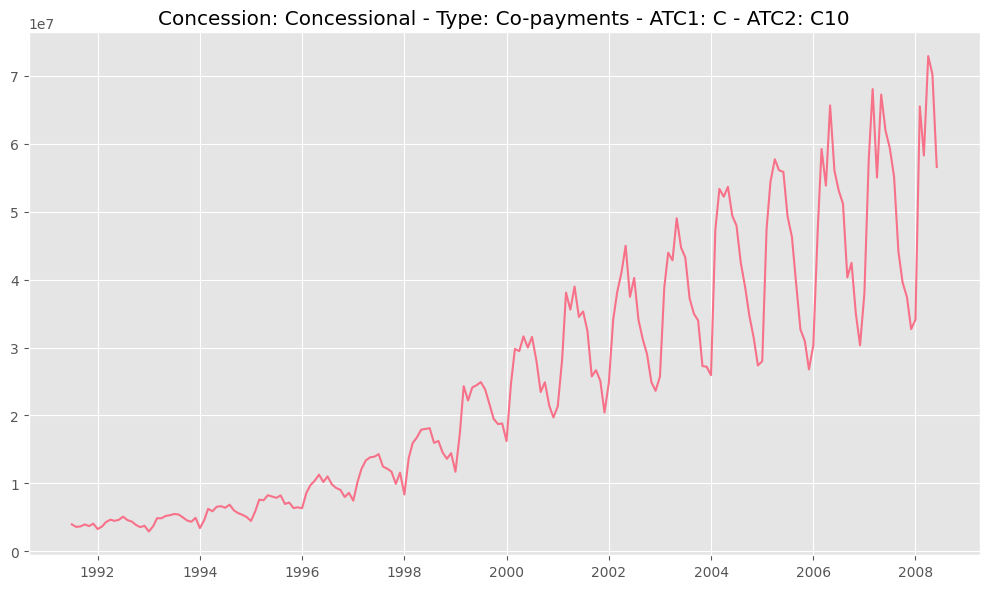

In [14]:
pbs_concession, pbs_type, pbs_atc1, pbs_atc2 = pbs_feat.loc[
    pbs_feat["mean"].idxmax()
].name
max_mean_rows = pbs[
    (pbs["Concession"] == pbs_concession)
    & (pbs["Type"] == pbs_type)
    & (pbs["ATC1"] == pbs_atc1)
    & (pbs["ATC2"] == pbs_atc2)
]
plot_series(
    df=max_mean_rows,
    id_col="Concession",
    time_col="Month",
    target_col="Cost",
    xlabel="",
    ylabel="",
    title=f"Concession: {pbs_concession} - Type: {pbs_type} - ATC1: {pbs_atc1} - ATC2: {pbs_atc2}",
)

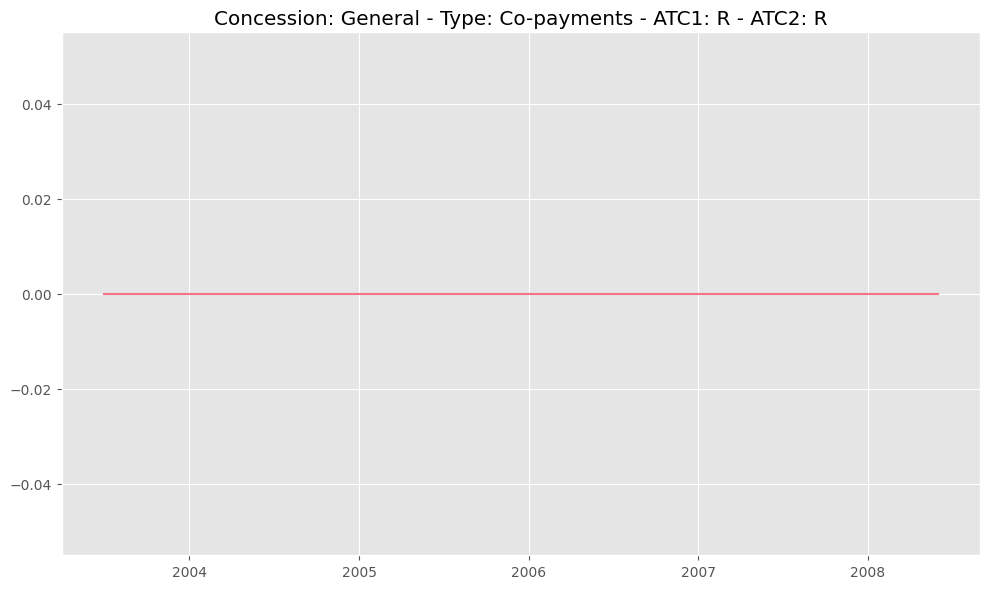

In [15]:
pbs_concession, pbs_type, pbs_atc1, pbs_atc2 = pbs_feat.loc[
    pbs_feat["std"].idxmin()
].name
min_std_rows = pbs[
    (pbs["Concession"] == pbs_concession)
    & (pbs["Type"] == pbs_type)
    & (pbs["ATC1"] == pbs_atc1)
    & (pbs["ATC2"] == pbs_atc2)
]
plot_series(
    df=min_std_rows,
    id_col="Concession",
    time_col="Month",
    target_col="Cost",
    xlabel="",
    ylabel="",
    title=f"Concession: {pbs_concession} - Type: {pbs_type} - ATC1: {pbs_atc1} - ATC2: {pbs_atc2}",
)

## Question 2

In [16]:
stl_feat = aus_tourism.groupby("unique_id", as_index=False)["y"].agg(
    [
        ("trend_strength", lambda x: get_trend_strength(x, period=4)),
        ("seasonal_strength", lambda x: get_seasonal_strength(x, period=4)),
        ("peak", lambda x: get_peak(x, period=4)),
        ("trough", lambda x: get_trough(x, period=4)),
        ("e_acf1", lambda x: get_e_acf1(x, period=4)),
        ("e_acf10", lambda x: get_e_acf10(x, period=4)),
    ]
)
stl_feat.head(10)

,unique_id,trend_strength,seasonal_strength,peak,trough,e_acf1,e_acf10
0,Adelaide Hills-South Australia-Business,0.460,0.168,3,4,-0.594,0.502
1,Adelaide Hills-South Australia-Holiday,0.531,0.295,2,4,-0.456,0.342
2,Adelaide Hills-South Australia-Other,0.590,0.407,2,2,-0.295,0.273
3,Adelaide Hills-South Australia-Visiting,0.487,0.248,4,3,-0.474,0.438
4,Adelaide-South Australia-Business,0.462,0.391,3,1,-0.538,0.577
5,Adelaide-South Australia-Holiday,0.578,0.638,1,2,-0.525,0.600
6,Adelaide-South Australia-Other,0.746,0.209,2,3,-0.368,0.412
7,Adelaide-South Australia-Visiting,0.449,0.476,1,2,-0.504,1.000
8,Alice Springs-Northern Territory-Business,0.552,0.302,3,1,-0.481,0.519
9,Alice Springs-Northern Territory-Holiday,0.379,0.832,3,1,-0.529,0.709


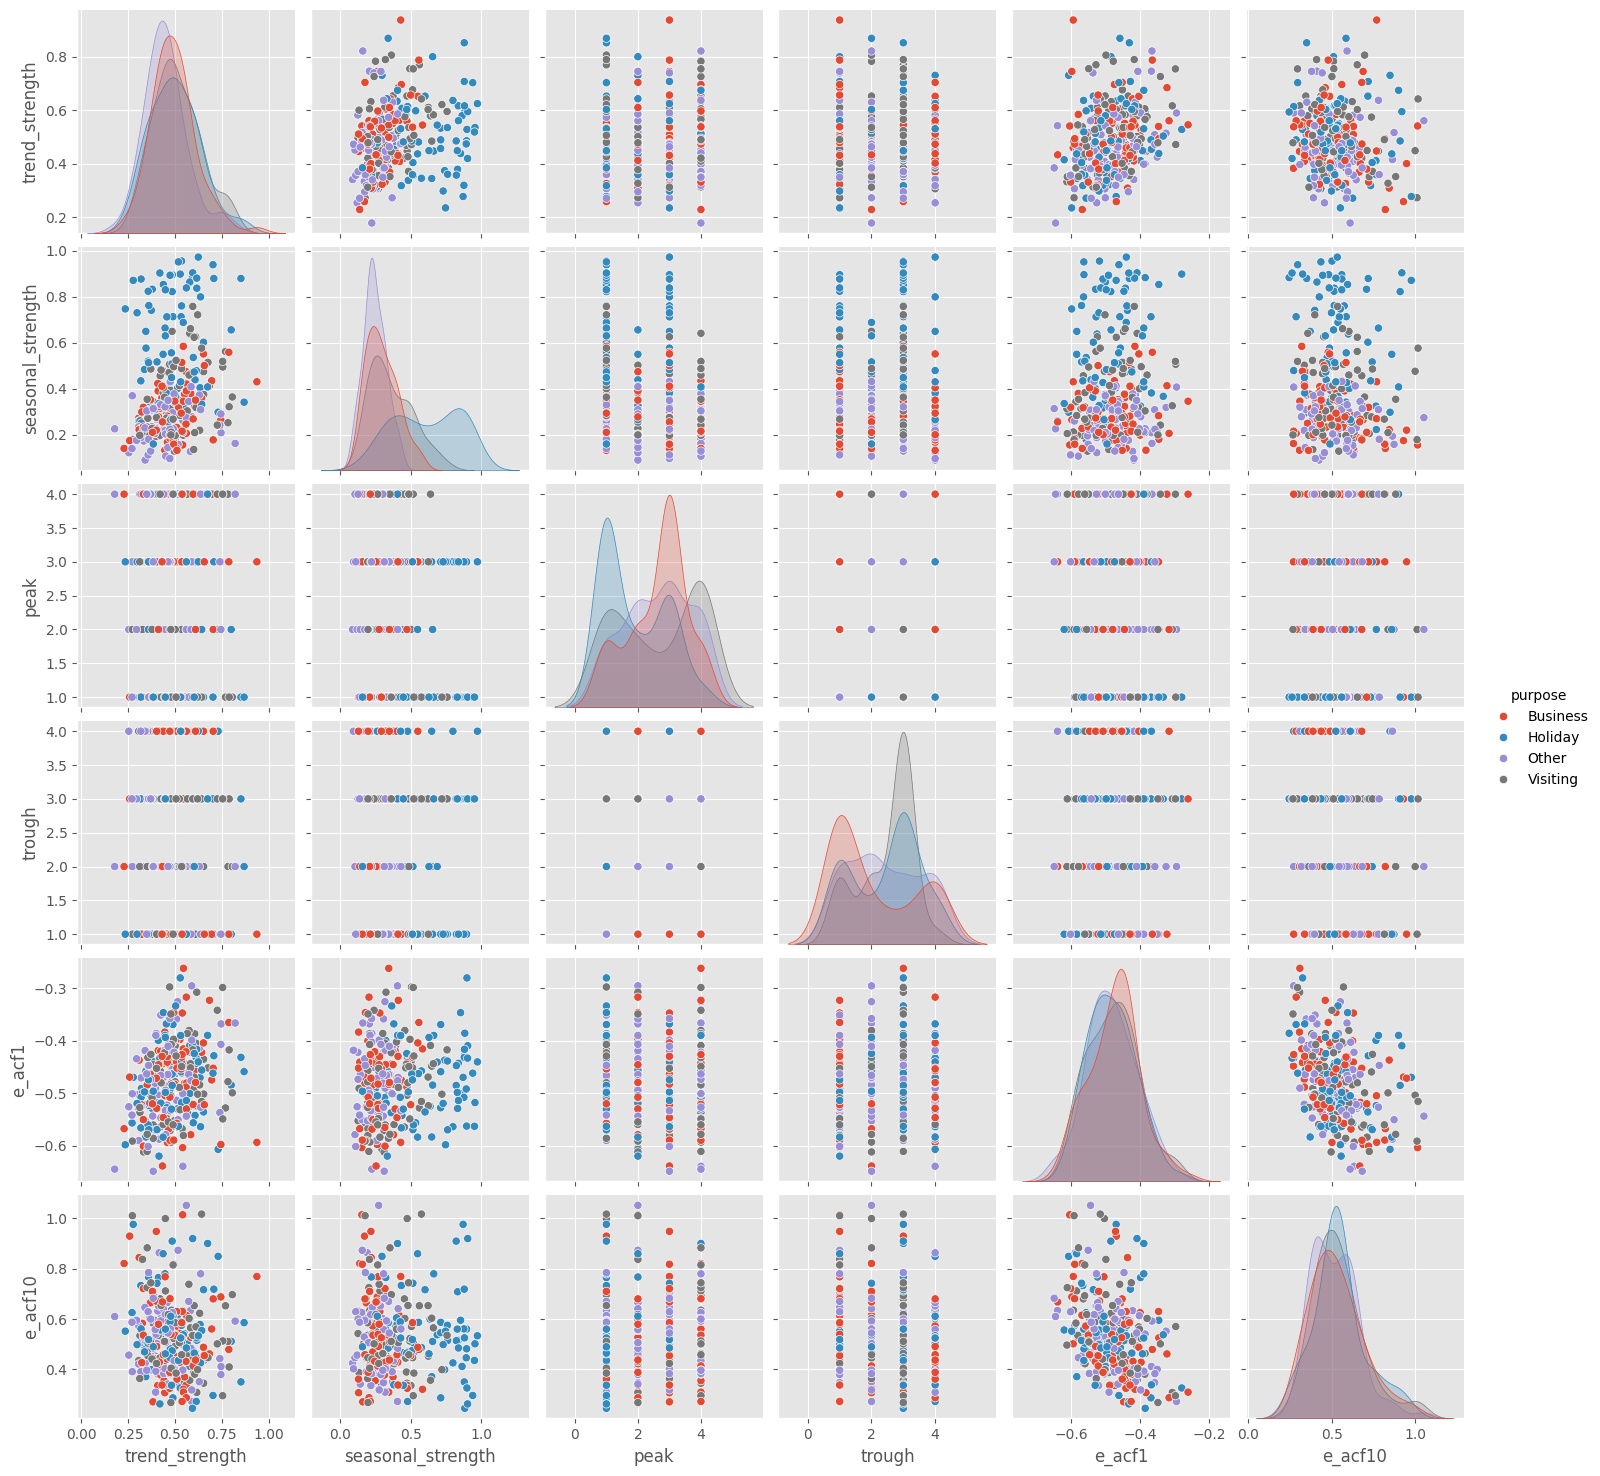

In [17]:
stl_feat[["region", "state", "purpose"]] = stl_feat["unique_id"].str.split(
    "-", expand=True
)
g = sns.pairplot(stl_feat, hue="purpose")
plt.show()

In [18]:
stl_feat[stl_feat["purpose"] == "Holiday"].groupby("state")["peak"].max()

state
ACT                   1
New South Wales       4
Northern Territory    3
Queensland            3
South Australia       4
Tasmania              1
Victoria              3
Western Australia     3
Name: peak, dtype: int64